--- Agent 1: Output ---
Found 7 answer regions, sorted top-to-bottom:
  Region 1: [x=1434, y=930, w=57, h=60]
  Region 2: [x=1452, y=1101, w=48, h=96]
  Region 3: [x=1440, y=1285, w=64, h=44]
  Region 4: [x=1439, y=1424, w=51, h=62]
  Region 5: [x=1436, y=1585, w=69, h=46]
  Region 6: [x=1430, y=1909, w=67, h=68]
  Region 7: [x=1035, y=2093, w=66, h=53]


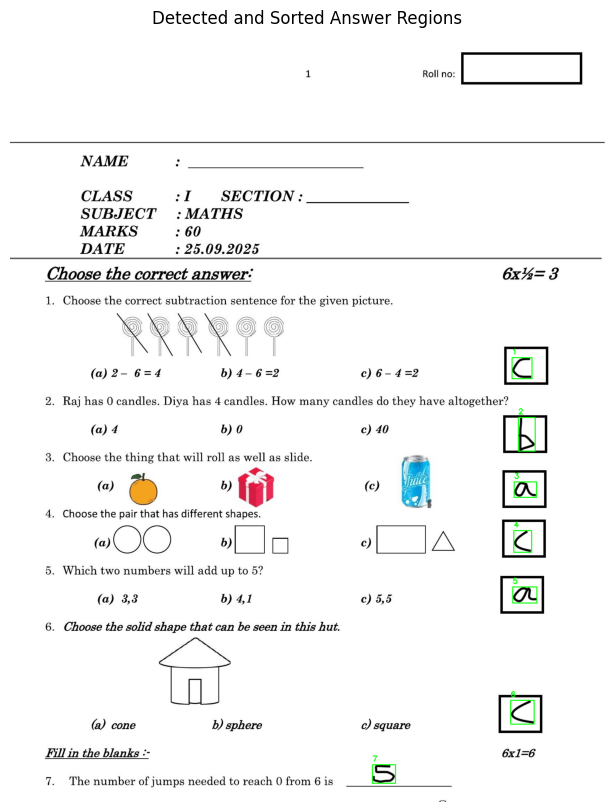

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load and Pre-process Images ---
img_blank = cv2.imread('/Users/gaurav/Downloads/2.jpg')
img_filled = cv2.imread('/Users/gaurav/Downloads/2 (1).jpg')

# Copy the filled image to draw on later
img_with_boxes = img_filled.copy()

# Convert to grayscale
gray_blank = cv2.cvtColor(img_blank, cv2.COLOR_BGR2GRAY)
gray_filled = cv2.cvtColor(img_filled, cv2.COLOR_BGR2GRAY)

# Resize filled image to match blank image's shape
h, w = gray_blank.shape
gray_filled = cv2.resize(gray_filled, (w, h))

# Apply blur to reduce minor noise
gray_blank = cv2.GaussianBlur(gray_blank, (5,5), 0)
gray_filled = cv2.GaussianBlur(gray_filled, (5,5), 0)

# --- 2. Find Differences ---
diff = cv2.absdiff(gray_blank, gray_filled)

# --- 3. Threshold and Clean Up ---
# Binarize the difference image
_, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

# Clean up the image to get solid blobs for each word/letter
kernel = np.ones((7,7), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

kernel_h = np.ones((5, 100), np.uint8) # <-- NEW
merged_regions = cv2.dilate(clean, kernel_h, iterations=1) # <-- NEW
#
# --- *** END OF NEW STEP *** ---


# --- 4. Find and Sort Regions ---
#
# Find contours on the *new merged_regions image* instead of the 'clean' one.
# This will now find one contour for "New Delhi" instead of two.
contours, _ = cv2.findContours(merged_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # <-- UPDATED

bounding_boxes = []
for c in contours:
    # Get the bounding box (x, y, width, height)
    x, y, w, h = cv2.boundingRect(c)
    
    # Filter out tiny noise (your 100-pixel-area filter is good)
    if (w * h) > 100:
        bounding_boxes.append((x, y, w, h))

# *** THIS IS THE MOST IMPORTANT STEP ***
# Sort the boxes from top-to-bottom based on their 'y' coordinate
# This ensures question 1 is first, question 2 is second, etc.
bounding_boxes.sort(key=lambda box: box[1])

# --- 5. Output Coordinates and Visualize ---

print("--- Agent 1: Output ---")
print(f"Found {len(bounding_boxes)} answer regions, sorted top-to-bottom:")

# Draw the sorted boxes on the image
for i, (x, y, w, h) in enumerate(bounding_boxes):
    print(f"  Region {i+1}: [x={x}, y={y}, w={w}, h={h}]")
    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img_with_boxes, str(i+1), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Display the final result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Detected and Sorted Answer Regions")
plt.axis("off")
plt.show()